In [1]:
#  fasion MNIST 이미지를  classifiaation하기
# 멀티클래스 VS 멀티레이블 구분하기
# 멀티클래스 : 어떤사진에 특정 클래스가 한개만 있는가 ([1,0,0], [0,1,0], [0,0,1])
# 멀티레이블 : 한 이미지에 우라가 관심있어하는 여러 레이블이 있음 ([0,0,0], [0,1,1],  [1,0,1] 등등...)
# 이미지 확장하기
# 이미지에 객체 삽입하기


# STEP 0. 필요모듈 임포트

In [2]:
# 필요모드 임포트

import tensorflow as tf
from tensorflow import keras
from keras.layers import Dense
from keras.models import Sequential

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
from IPython.display import Image

warnings.filterwarnings('ignore')
%matplotlib inline

SEED = 34

In [3]:
print("TensorFlow version:", tf.__version__)
print("Num GPUs Available:", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.10.0
Num GPUs Available: 1


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 12485497592884457499
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 6248464384
locality {
  bus_id: 1
  links {
  }
}
incarnation: 1427924595321125391
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2070 SUPER, pci bus id: 0000:07:00.0, compute capability: 7.5"
xla_global_id: 416903419
]


# STEP 1. 도입전 기본처리

In [5]:
# fasionMNIST 데이터 살펴보기
fashion_mnist = keras.datasets.fashion_mnist
((train_images,train_labels),(test_images,test_labels)) = fashion_mnist.load_data()

In [6]:
# train_images/labels와 test_images/labels의 shape 출력
print('train_images.shape : {}'.format(train_images.shape))
print('train_labels.shape : {}'.format(train_labels.shape))
print('test_images.shape : {}'.format(test_images.shape))
print('test_labels.shape : {}'.format(test_labels.shape))

train_images.shape : (60000, 28, 28)
train_labels.shape : (60000,)
test_images.shape : (10000, 28, 28)
test_labels.shape : (10000,)


In [7]:
# 레이블설정 (idx -> 품목이름)
labels = ["T-shirt/top",
         "Trouser",
         "Pullover",
         "Dress",
         "Coat",
         "Sendal",
         "Shirt",
         "Sneaker",
         "Bag",
         "Ankle boot"]

def idx2label(idx):
    return labels[idx]

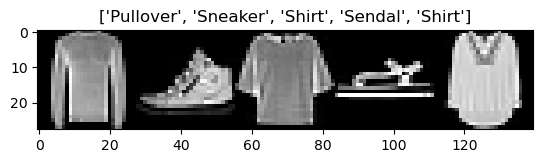

In [8]:
# (28, 28) 형태의 이미지를 plt 이용해 출력
indices = np.random.choice(range(len(train_images)), size=5, replace=False)
labels_sel = list(map(idx2label, train_labels[indices]))

def show_image(indices):    
    plt.imshow(train_images[indices].transpose((1,0,2)).reshape((28,-1)), cmap='gray')
    plt.title(labels_sel)
    plt.show()
    
show_image(indices)

In [9]:
# train_images에서 0이 아닌 값들을 출력
train_images[train_images!=0][:5]

array([ 1, 13, 73,  1,  4], dtype=uint8)

In [10]:
# train_images의 dtype을 출력
train_images.dtype

dtype('uint8')

In [11]:
# 이미지의 값이 중 가장 큰 idx와 가장 작은 idx을 출력
print(train_images.reshape(len(train_images),-1).sum(axis=1).argmax())
print(train_images.reshape(len(train_images),-1).sum(axis=1).argmin())

55023
9230


# STEP 2. 전처리

In [12]:
# train/test 이미지 범위 확인
# 이미지 데디터 범위 확인
print(train_images.shape, test_images.shape)
print(train_images.dtype, test_images.dtype)


(60000, 28, 28) (10000, 28, 28)
uint8 uint8


In [13]:
# train/test 이미지의 데이터 최소/최대값 출력
print("train_images Min/Max : {}/{}".format(train_images.min(), train_images.max()))
print("test_images Min/Max : {}/{}".format(test_images.min(), test_images.max()))
print("train_labels Min/Max : {}/{}".format(train_labels.min(), train_labels.max()))
print("test_labels Min/Max : {}/{}".format(test_labels.min(), test_labels.max()))
print("train_images type : {}".format(train_images.dtype))
print("test_images type : {}".format(test_images.dtype))

train_images Min/Max : 0/255
test_images Min/Max : 0/255
train_labels Min/Max : 0/9
test_labels Min/Max : 0/9
train_images type : uint8
test_images type : uint8


In [14]:
# 정수형을 실수형으로 변경 후 dtype으로 비교후 실수로 전환
train_images = train_images.astype(np.float64)
test_images = test_images.astype(np.float64)
print("train_images Min/Max : {}/{}".format(train_images.min(), train_images.max()))
print("test_images Min/Max : {}/{}".format(test_images.min(), test_images.max()))
print("train_images type : {}".format(train_images.dtype))
print("test_images type : {}".format(test_images.dtype))

train_images Min/Max : 0.0/255.0
test_images Min/Max : 0.0/255.0
train_images type : float64
test_images type : float64


In [15]:
# 데이터 0-1 노말라이즈 수행
def norm(data):
    min_v = data.min()
    max_v = data.max()
    return (data-min_v)/(max_v-min_v)


train_images = norm(train_images)
test_images = norm(test_images)

print(list(filter(lambda x : x != 0, train_images[0].reshape(-1)))[:10])
print(list(filter(lambda x : x != 0, train_labels.reshape(-1)))[:10])
print(list(filter(lambda x : x != 0, test_images[0].reshape(-1)))[:10])
print(list(filter(lambda x : x != 0, test_labels.reshape(-1)))[:10])

print("train_images Min/Max : {}/{}".format(train_images.min(), train_images.max()))
print("test_images Min/Max : {}/{}".format(test_images.min(), test_images.max()))
print("train_images 데이터 type : {}".format(train_images.dtype))
print("test_images 데이터 type : {}".format(test_images.dtype))
print("train_labels Min/Max : {}/{}".format(train_labels.min(), train_labels.max()))
print("test_labels Min/Max : {}/{}".format(test_labels.min(), test_labels.max()))
print("train_labels 데이터 type : {}".format(train_labels.dtype))
print("test_labels 데이터 type : {}".format(test_labels.dtype))

[0.00392156862745098, 0.050980392156862744, 0.28627450980392155, 0.00392156862745098, 0.01568627450980392, 0.00392156862745098, 0.00392156862745098, 0.011764705882352941, 0.1411764705882353, 0.5333333333333333]
[9, 3, 2, 7, 2, 5, 5, 9, 5, 5]
[0.011764705882352941, 0.00392156862745098, 0.027450980392156862, 0.1450980392156863, 0.00392156862745098, 0.00784313725490196, 0.10588235294117647, 0.32941176470588235, 0.043137254901960784, 0.4666666666666667]
[9, 2, 1, 1, 6, 1, 4, 6, 5, 7]
train_images Min/Max : 0.0/1.0
test_images Min/Max : 0.0/1.0
train_images 데이터 type : float64
test_images 데이터 type : float64
train_labels Min/Max : 0/9
test_labels Min/Max : 0/9
train_labels 데이터 type : uint8
test_labels 데이터 type : uint8


# STEP 3. 시각화 방법

In [16]:
# train_image의 이미지를 5장 획득하여 (5,28,28)의 shape을 출력
indices = np.random.choice(range(len(train_images)), size=5, replace=False)
train_images[indices].shape

(5, 28, 28)

(28, 140)


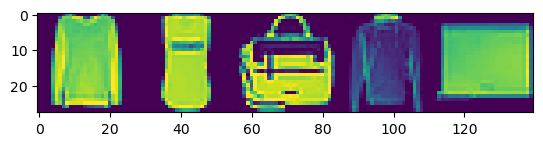

In [17]:
# hstack을 이용한 변환
print(np.hstack(train_images[indices]).shape)
plt.imshow(np.hstack(train_images[indices]))

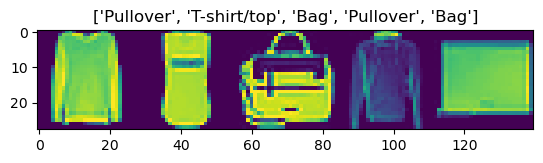

In [18]:
# np.hstack은 tensorflow에서 사용가능한 방법이 아니므로 transpose 함수를 이용하여 (28,28,5)을 변환
# numpy는 CPU 영역에서 동작하기 때문에 GPU를 최대한 활용하기 위해서는 tanspose 함수 쓰기

labels_sel = list(map(idx2label, train_labels[indices]))
# print(train_images[indices].transpose(1, 0, 2).reshape(28, -1).shape) # (batch, height, width) -> (height, batch, width)로 변환
plt.imshow(train_images[indices].transpose(1, 0, 2).reshape(28, -1)) # 그냥 reshape으로 변환하면 imshow에서 받아들이지 못함
plt.title(labels_sel)
plt.show()
# print("labels : {}".format(train_labels[indices]))

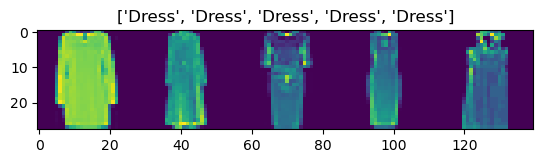

In [19]:
# 레이블에 따라 5개르 출력하는 함수
target_idx = 3


indices = np.where(train_labels == target_idx)[0]
indices = np.random.choice(indices, size=5, replace=False)
labels_sel = list(map(idx2label, train_labels[indices]))
plt.imshow(train_images[indices].transpose(1, 0, 2).reshape(28, -1)) # 그냥 reshape으로 변환하면 imshow에서 받아들이지 못함
plt.title(labels_sel)
plt.show()


# STEP 4. Data augmentation - 이미지 확개 및 다객체 추가 방법

In [20]:
# 이미지 한장의 크기를 4배로 확대하고, 객체는 4분면 영역 중 랜덤으로 1공간에 넣는 함수
def expand_4times(img):
    bg = np.zeros(img.shape)
    # 2 1
    # 3 4
    idx = np.random.randint(0,4)
    
    slots = [bg, bg, bg, bg]
    slots[idx] = img
    
    expanded = np.vstack([
        np.hstack(slots[:2]),
        np.hstack(slots[2:])        
    ])
    return expanded


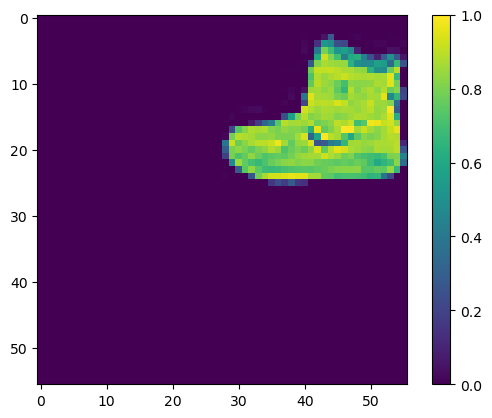

In [21]:
plt.imshow(expand_4times(train_images[0]))
plt.colorbar()

In [22]:
# 4배 이미지 변환을 전체 train/test 데이터에 실행하여 train_expand_images, test_expand_images를 생성
train_expand_images = np.array([expand_4times(img) for img in train_images])
test_expand_images = np.array([expand_4times(img) for img in test_images])

In [23]:
print("train_expand_images Min/Max : {}/{}".format(train_expand_images.min(), train_expand_images.max()))
print("test_expand_images Min/Max : {}/{}".format(test_expand_images.min(), test_expand_images.max()))
print("train_expand_images 데이터 type : {}".format(train_expand_images.dtype))
print("test_expand_images 데이터 type : {}".format(test_expand_images.dtype))
print('train_expand_images.shape : {}'.format(train_expand_images.shape))
print('test_expand_images.shape : {}'.format(test_expand_images.shape))
print('train_labels.shape : {}'.format(train_labels.shape))
print('test_labels.shape : {}'.format(test_labels.shape))

train_expand_images Min/Max : 0.0/1.0
test_expand_images Min/Max : 0.0/1.0
train_expand_images 데이터 type : float64
test_expand_images 데이터 type : float64
train_expand_images.shape : (60000, 56, 56)
test_expand_images.shape : (10000, 56, 56)
train_labels.shape : (60000,)
test_labels.shape : (10000,)


In [24]:
# 4배 이미지 변환 함수를 수정하여 이미지 사이즈를 4배 확대 시킨 뒤, 객체를 랜덤하게 0~4개, 랜덤 4분면에 위치시키는 한수 

def expand_4times2(x_data, y_data):
    images = []
    labels = []
    
    for _ in range(4):
        bg = np.zeros((28,28))
        obj_count = np.random.randint(0,5)
        
        label = np.zeros((10,))
        slots = [bg, bg, bg, bg]
        for idx in range(obj_count):
            i = np.random.randint(len(x_data))
            slots[idx] = x_data[i]
            label += tf.keras.utils.to_categorical(y_data[i],10)
            
        np.random.shuffle(slots)
        
    new_img = np.vstack([
        np.hstack(slots[:2]),
        np.hstack(slots[2:])
    ])
    
    images.append(new_img)
    labels.append((label>=1).astype(np.int))
    
    return np.array(images), np.array(labels)


[[0 0 0 0 0 1 0 0 0 0]]


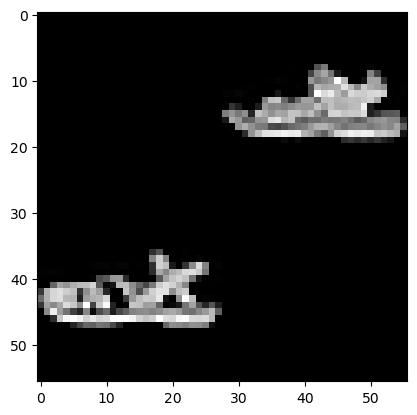

In [25]:
rand_img, rand_label = expand_4times2(train_images, train_labels)
plt.imshow(rand_img[0],cmap='gray')
print(rand_label)

In [26]:
# 4배 이미지 변환을 전체 train/test 데이터를 실행하여 train_multi_images, test_multi_images, train_multi_labels, test_multi_labels를 생성
train_multi_images, train_multi_labels = list(zip(*[expand_4times2(train_images, train_labels) for i in train_images]))
test_multi_images, test_multi_labels = list(zip(*[expand_4times2(test_images, test_labels) for i in test_images]))

In [27]:
train_multi_images = np.array(train_multi_images).reshape(-1,56,56,1)
train_multi_labels = np.array(train_multi_labels).reshape(-1,10)

test_multi_images = np.array(test_multi_images).reshape(-1,56,56,1)
test_multi_labels = np.array(test_multi_labels).reshape(-1,10)

print('train_multi_images.shape : {}'.format(train_multi_images.shape))
print('test_multi_images.shape : {}'.format(test_multi_images.shape))
print('train_multi_labels.shape : {}'.format(train_multi_labels.shape))
print('test_multi_labels.shape : {}'.format(test_multi_labels.shape))

train_multi_images.shape : (60000, 56, 56, 1)
test_multi_images.shape : (10000, 56, 56, 1)
train_multi_labels.shape : (60000, 10)
test_multi_labels.shape : (10000, 10)


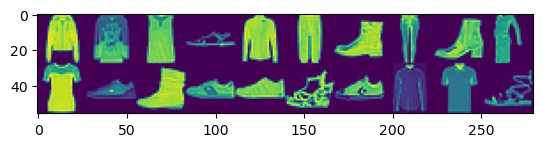

In [28]:
# 개수에 따라 연속된 그림을 보여주는 함수
target_num_labels = 4

indices = np.where(train_multi_labels.sum(axis=1) == target_num_labels)[0]
indices = np.random.choice(indices, size=5, replace=False)
plt.imshow(train_multi_images[indices].transpose(1, 0, 2,3).reshape(56, -1)) # 그냥 reshape으로 변환하면 imshow에서 받아들이지 못함
plt.show()
# plt.imshow(train_multi_labels[2],cmap='gray')


In [29]:
# multi label과 train label 값의 형태를 비교
print(train_labels[2])
print(train_multi_labels[2])

0
[0 0 0 0 0 0 0 0 0 1]


<BarContainer object of 10 artists>

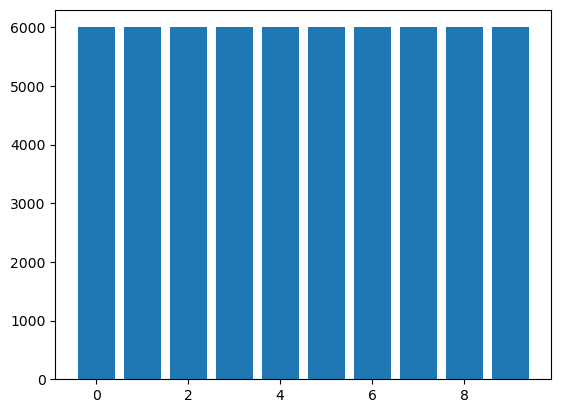

In [30]:
# train_labels에서 label들의 분포를 구해보기
plt.bar([0,1,2,3,4,5,6,7,8,9], tf.keras.utils.to_categorical(train_labels).sum(axis=0))

<BarContainer object of 10 artists>

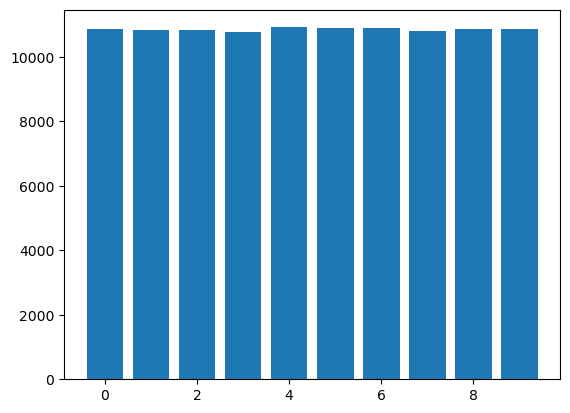

In [31]:

plt.bar([0,1,2,3,4,5,6,7,8,9], train_multi_labels.sum(axis=0))

(array([11980.,     0., 13370.,     0.,     0., 14758.,     0., 13869.,
            0.,  6023.]),
 array([0. , 0.4, 0.8, 1.2, 1.6, 2. , 2.4, 2.8, 3.2, 3.6, 4. ]),
 <a list of 10 Patch objects>)

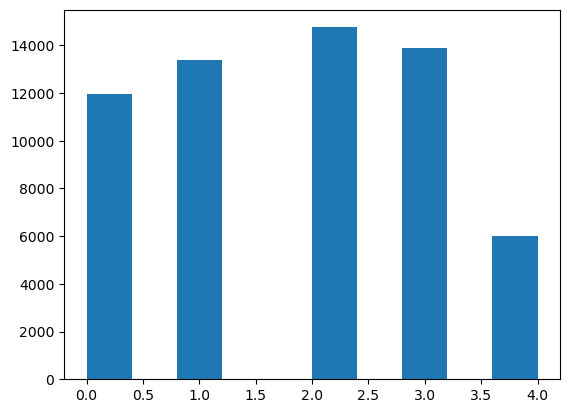

In [32]:
# multi labels들의 분포와 multi images에서 평균 사진개수 분포 구하기
plt.hist(train_multi_labels.sum(axis=1))

# STEP 5. 모델링 
## transfer learning 컨셉 이용

In [33]:
from keras.layers import Input, Conv2D, MaxPool2D, Dropout, Dense, Flatten, GlobalAvgPool2D
from keras.models import Model


In [34]:
# train_expand_images, train_labels로 싱글 label을 처리하는 image classification 초벌 모델 생성

def single_fasion_mnist_model():
    inputs = Input((56,56,1))
    x = Conv2D(16, 2, padding="same", activation="relu")(inputs)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(32, 2, padding="same", activation="relu")(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, 2, padding="same", activation="relu")(x)
    x = MaxPool2D(2)(x)
    x = Flatten()(x)
    x = Dense(10, activation = 'softmax')(x)
    
    return Model(inputs, x)

def single_fasion_mnist_model2():
    inputs = Input((56,56,1))
    x = Conv2D(16, 2, padding="same", activation="relu")(inputs)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(32, 2, padding="same", activation="relu")(x)
    x = MaxPool2D(2)(x)
    x = Dropout(0.3)(x)
    
    x = Conv2D(64, 2, padding="same", activation="relu")(x)
    x = MaxPool2D(2)(x)
    x = GlobalAvgPool2D()(x)  
    x = Dense(10, activation = 'softmax')(x)
    
    return Model(inputs, x)



    
    
    

In [35]:
# 모델을 할당받고 서머리 출력
model = single_fasion_mnist_model()
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 56, 56, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 56, 56, 16)        80        
                                                                 
 max_pooling2d (MaxPooling2D  (None, 28, 28, 16)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 28, 28, 16)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                         

In [53]:
model = single_fasion_mnist_model2()
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 56, 56, 1)]       0         
                                                                 
 conv2d_6 (Conv2D)           (None, 56, 56, 16)        80        
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 28, 28, 16)       0         
 2D)                                                             
                                                                 
 dropout_4 (Dropout)         (None, 28, 28, 16)        0         
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 32)        2080      
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                       

In [54]:
# 만든 모델에 로스와 옵티마이저, 메트릭 설정
model.compile(loss ="categorical_crossentropy", optimizer="adam", metrics =["accuracy"])

In [55]:
train_expand_images_dataset = train_expand_images[..., tf.newaxis]
test_expand_images_dataset = test_expand_images[..., tf.newaxis]

train_dataset = tf.data.Dataset.from_tensor_slices((train_expand_images_dataset, tf.keras.utils.to_categorical(train_labels,10)))
validation_dataset = tf.data.Dataset.from_tensor_slices((test_expand_images_dataset, tf.keras.utils.to_categorical(test_labels,10)))
# type(train_dataset)
# dir(train_dataset)
train_expand_images_dataset.shape

(60000, 56, 56, 1)

In [56]:
batch_size = 1024
train_dataset = (train_dataset
                 .shuffle(buffer_size=10000)
                 .batch(batch_size)
                 .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))

validation_dataset = (validation_dataset
                      .batch(batch_size)
                      .prefetch(buffer_size=tf.data.experimental.AUTOTUNE))


In [57]:
# 만든 모델에 train_expand_images를 학습
# hist = model.fit(train_expand_images.reshape(-1,56,56,1), 
#                 tf.keras.utils.to_categorical(train_labels,10),
#                 validation_data = (test_expand_images.reshape(-1,56,56,1), 
#                 tf.keras.utils.to_categorical(test_labels,10)),
#                 epochs = 15,
#                 verbose = 1
#                 )

hist = model.fit(train_dataset, validation_data=validation_dataset,
                epochs = 15,
                verbose = 1
                )

Epoch 1/15
59/59 [==============================] - 3s 37ms/step - loss: 2.2606 - accuracy: 0.1297 - val_loss: 2.1719 - val_accuracy: 0.2833
Epoch 2/15
59/59 [==============================] - 2s 34ms/step - loss: 1.9292 - accuracy: 0.3340 - val_loss: 1.7634 - val_accuracy: 0.3510
Epoch 3/15
59/59 [==============================] - 2s 34ms/step - loss: 1.5981 - accuracy: 0.4173 - val_loss: 1.4807 - val_accuracy: 0.4504
Epoch 4/15
59/59 [==============================] - 2s 34ms/step - loss: 1.4228 - accuracy: 0.4652 - val_loss: 1.3501 - val_accuracy: 0.4946
Epoch 5/15
59/59 [==============================] - 2s 34ms/step - loss: 1.3249 - accuracy: 0.5037 - val_loss: 1.2770 - val_accuracy: 0.5247
Epoch 6/15
59/59 [==============================] - 2s 34ms/step - loss: 1.2564 - accuracy: 0.5301 - val_loss: 1.2390 - val_accuracy: 0.5315
Epoch 7/15
59/59 [==============================] - 2s 34ms/step - loss: 1.1953 - accuracy: 0.5577 - val_loss: 1.1735 - val_accuracy: 0.5755
Epoch 8/15
59

In [41]:
#  학습 진행 사항을 출력
